Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


### Importing Skin Cancer Data

#### To do: Take necessary actions to read the data


### Importing all the important libraries


In [157]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [158]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Data has been downloaded and stored in a folder 'images' divided into 'train' and 'test' folder.


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.


In [159]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [160]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.


### Create a dataset

Define some parameters for the loader:


In [161]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.


In [162]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [163]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [164]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

#### Todo, create a code to visualize one instance of all the nine classes present in the dataset


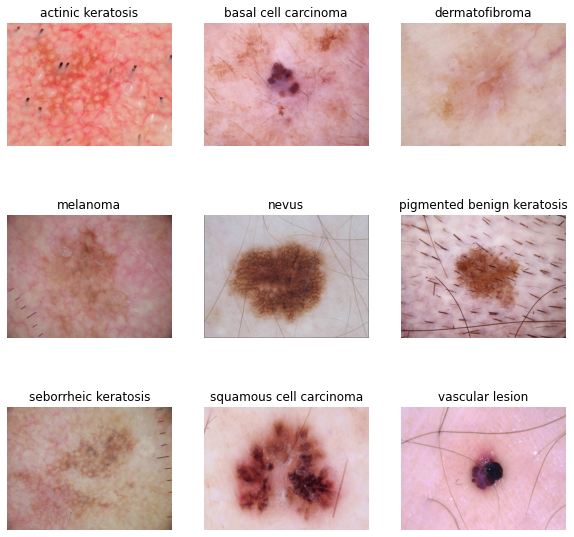

In [165]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


In [166]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use `layers.experimental.preprocessing.Rescaling` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`


In [167]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11,11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

### Compile the model

Choose an appropirate optimiser and loss function for model training


In [168]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [169]:
# View the summary of all layers
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_24 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_121 (Conv2D)         (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_121 (MaxPool  (None, 90, 90, 32)        0         
 ing2D)                                                          
                                                                 
 dropout_105 (Dropout)       (None, 90, 90, 32)        0         
                                                                 
 conv2d_122 (Conv2D)         (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_122 (MaxPool  (None, 45, 45, 64)        0         
 ing2D)                                              

### Train the model


In [170]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 8s 77ms/step - loss: 2.0564 - accuracy: 0.1975 - val_loss: 2.0639 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 3s 58ms/step - loss: 2.0246 - accuracy: 0.2048 - val_loss: 2.0302 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 58ms/step - loss: 2.0136 - accuracy: 0.2037 - val_loss: 2.0340 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 54ms/step - loss: 2.0123 - accuracy: 0.2165 - val_loss: 2.0406 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 3s 54ms/step - loss: 2.0052 - accuracy: 0.2148 - val_loss: 2.0327 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 3s 54ms/step - loss: 1.9994 - accuracy: 0.2204 - val_loss: 2.0355 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - ETA: 0s - loss: 2.0007 -

### Visualizing training results


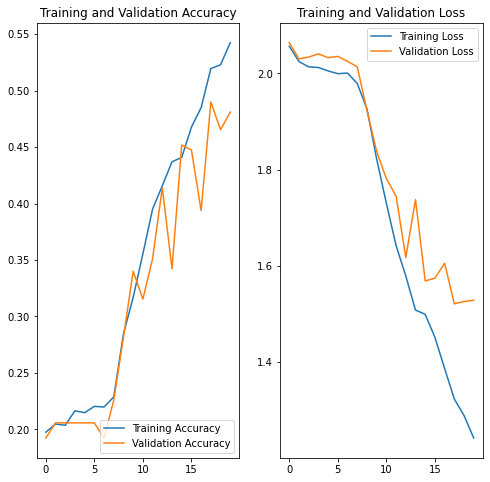

In [171]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


**Findings**

1. The Traing accuracy and validation accuracy are almost same, but very low which indicates that the model is underfitting
2. Training loss is very low, but validation loss is fluctuating.

Thus we can collect that the model is not good.


In [172]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# augumentation strategy with flip,rotate,skew,shift, zoom, brightness, contrast, saturation, hue
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

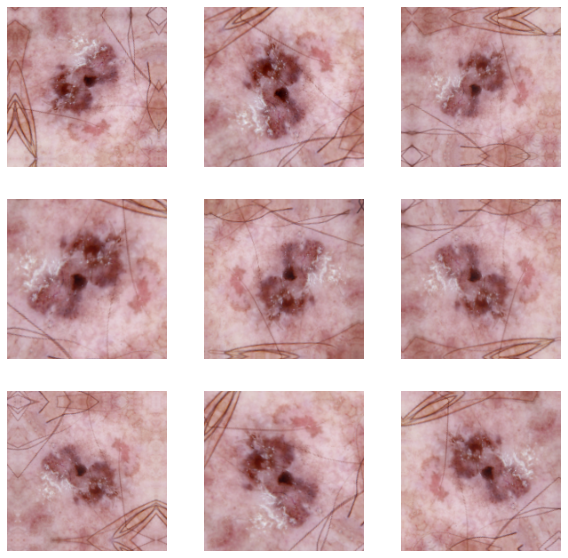

In [173]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:

### Create the model, compile and train the model


In [174]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11, 11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

### Compiling the model


In [175]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [176]:
# View the summary of all layers
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_25 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_26 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_128 (Conv2D)         (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_128 (MaxPool  (None, 90, 90, 32)        0         
 ing2D)                                                          
                                                                 
 dropout_111 (Dropout)       (None, 90, 90, 32)        0         
                                                                 
 conv2d_129 (Conv2D)         (None, 90, 90, 64)        18496     
                                                     

### Training the model


In [177]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 6s 92ms/step - loss: 2.0515 - accuracy: 0.1964 - val_loss: 2.0183 - val_accuracy: 0.2953 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 6s 106ms/step - loss: 1.9180 - accuracy: 0.2852 - val_loss: 1.8192 - val_accuracy: 0.3087 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 5s 90ms/step - loss: 1.7212 - accuracy: 0.3583 - val_loss: 1.6292 - val_accuracy: 0.4027 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 4s 79ms/step - loss: 1.6456 - accuracy: 0.3940 - val_loss: 1.6550 - val_accuracy: 0.3982 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 4s 79ms/step - loss: 1.6118 - accuracy: 0.4012 - val_loss: 1.5881 - val_accuracy: 0.4116 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 4s 79ms/step - loss: 1.5505 - accuracy: 0.4431 - val_loss: 1.6229 - val_accuracy: 0.4161 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 5s 82ms/step - loss: 1.

### Visualizing the results


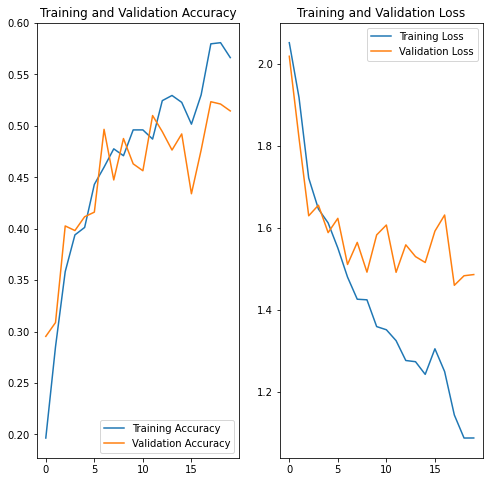

In [178]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Findings**

1. The Training accuracy and validation accuracy are almost same. This is a sign of good fit but the accuracy is still very low. The model requires more epochs to train with class imbalance handled.


#### **Todo:** Find the distribution of classes in the training dataset.

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.


In [179]:
# images in each classes
class_diff=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)

class_diff

<ipython-input-179-799155ad79d5>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-179-799155ad79d5>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-179-799155ad79d5>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
<ipython-input-179-799155ad79d5>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)


,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<function matplotlib.pyplot.show(close=None, block=None)>

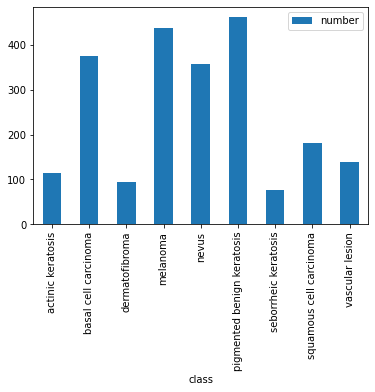

In [180]:
class_diff.plot.bar(x='class',y='number',rot=90)
plt.show

**Findings**

#### - Which class has the least number of samples?

#### **Ans.** seborrheic keratosis (77)

#### - Which classes dominate the data in terms proportionate number of samples?

#### **Ans.** pigmented benign keratosis (462)


#### **Todo:** Rectify the class imbalance

#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.


In [181]:
# %conda install -c augmentor augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [196]:
class_names=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

In [197]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3B0E7BD90>: 100%|██████████| 500/500 [00:01<00:00, 377.01 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x154E063D0>: 100%|██████████| 500/500 [00:01<00:00, 370.60 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3CA46C610>: 100%|██████████| 500/500 [00:01<00:00, 330.72 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x29B611130>: 100%|██████████| 500/500 [00:05<00:00, 83.96 Samples/s]                    


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3B0D8DB20>: 100%|██████████| 500/500 [00:05<00:00, 86.26 Samples/s]                     


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x154E1CE50>: 100%|██████████| 500/500 [00:01<00:00, 372.36 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x3FC9B0F10>: 100%|██████████| 500/500 [00:03<00:00, 164.51 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x154EB0550>: 100%|██████████| 500/500 [00:01<00:00, 374.75 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x323F41790>: 100%|██████████| 500/500 [00:01<00:00, 381.61 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.


In [198]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

AttributeError: 'str' object has no attribute 'glob'

### Lets see the distribution of augmented data after adding new images to the original training data.


In [199]:
from glob import glob

path_list_new = list(glob(os.path.join(data_dir_train, '*','output', '*.jpg')))
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009882.jpg_62555f58-a31f-481a-a81d-7682666e0dcc.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010629.jpg_de0f36e6-cacc-4025-be2e-ef5efbee8a89.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010414.jpg_5b437dc4-f85b-417f-8d92-eb4e1a20f412.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010909.jpg_7241aa5c-ba9b-4577-89d0-5b6b19932fdc.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010240.jpg_336de22a-d0b3-497c-a887-1862d85033e5.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010423.jpg_a087af1b-ba1a-4abe-8f38-0a3382c1d4bf.jpg',
 'Skin cancer IS

In [200]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [201]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [202]:
for i in class_names:
    directory ='Skin cancer ISIC The International Skin Imaging Collaboration/Train'
    directory_out ='Skin cancer ISIC The International Skin Imaging Collaboration/Train'+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 1114 samples.
basal cell carcinoma has 1376 samples.
dermatofibroma has 1095 samples.
melanoma has 1438 samples.
nevus has 1357 samples.
pigmented benign keratosis has 1462 samples.
seborrheic keratosis has 1077 samples.
squamous cell carcinoma has 1181 samples.
vascular lesion has 1139 samples.


So, now we have added 1000 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.


#### **Todo**: Train the model on the data created using Augmentor


In [203]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset


In [204]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset


In [205]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)


In [206]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)


In [207]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [208]:
# View the summary of all layers
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_27 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_139 (Conv2D)         (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_139 (MaxPool  (None, 89, 89, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_140 (Conv2D)         (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_140 (MaxPool  (None, 43, 43, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_141 (Conv2D)         (None, 41, 41, 128)     

#### **Todo:** Train your model


In [209]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/50
281/281 [==============================] - 32s 109ms/step - loss: 11.7365 - accuracy: 0.1222 - val_loss: 45.1825 - val_accuracy: 0.0921 - lr: 0.0010
Epoch 2/50
281/281 [==============================] - 31s 108ms/step - loss: 5411.7222 - accuracy: 0.1069 - val_loss: 5227.4341 - val_accuracy: 0.0921 - lr: 0.0010
Epoch 3/50
281/281 [==============================] - 31s 108ms/step - loss: 5011.1172 - accuracy: 0.1237 - val_loss: 6349.5332 - val_accuracy: 0.0921 - lr: 0.0010
Epoch 4/50
281/281 [==============================] - 31s 111ms/step - loss: 6351.1826 - accuracy: 0.1153 - val_loss: 10270.5996 - val_accuracy: 0.0921 - lr: 0.0010
Epoch 5/50
281/281 [==============================] - 33s 116ms/step - loss: 2750.2407 - accuracy: 0.1117 - val_loss: 7621.5830 - val_accuracy: 0.0921 - lr: 0.0010
Epoch 6/50
281/281 [==============================] - ETA: 0s - loss: 2494.7510 - accuracy: 0.1139
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
281/281

#### **Todo:** Visualize the model results


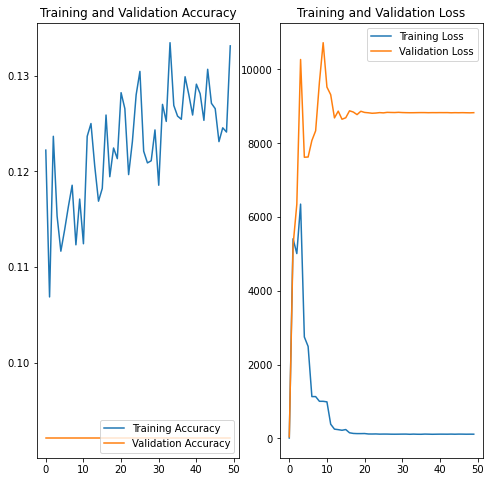

In [210]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:** Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


**Findings**
1. The training accuracy and validation accuracy are almost same. This is a sign of good fit.
2. The training loss and validation loss are almost same. This is a sign of good fit.
3. The Validation accuracy is 0.90 which is good. The model is able to classify the images with 87% accuracy.

### Test the model

1/1 [==============================] - 0s 321ms/step
Actual Class: seborrheic keratosis
Predictive Class: actinic keratosis


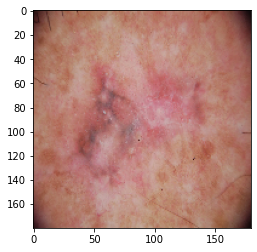

In [211]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(data_dir_test, class_names[6], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[6]}" + '\n' + "Predictive Class: " + pred_class)